#Import Libraries

In [3]:
import torch
import gensim
import gensim.downloader as api
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import pandas as pd
from bs4 import BeautifulSoup
!pip install symspellpy
from symspellpy import SymSpell
!pip install contractions
import contractions
import pkg_resources
import contractions as ct
import re
import warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 KB 16.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 14.2 MB/s eta 0:00:00


#Load Word2vec Model

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
wv = api.load('word2vec-google-news-300')

Mounted at /content/drive
[====----------------------------------------------] 8.9% 148.2/1662.8MB downloaded

#Define Functions

In [ ]:
def init_data(data_frame):
    data_frame.dropna(inplace=True)
    data_frame.drop_duplicates(inplace=True)
    data_frame['star_rating'] = data_frame['star_rating'].astype('int')
    return data_frame

In [ ]:
def init_spell_checker():
    sym_spell_obj = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt"
    )
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
    )
    sym_spell_obj.load_dictionary(dictionary_path, term_index=0, count_index=1)
    sym_spell_obj.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

    return sym_spell_obj

In [ ]:
def spell_correct(text):
    input_term = text
    suggestions = sym_spell.lookup_compound(
        input_term, max_edit_distance=2, transfer_casing=True
    )
    return suggestions[0].term

In [ ]:
def exclude_words_not_in_w2v(review_body_string):
    word_list = review_body_string.split()
    buffer_string = ""

    for w in word_list:
        if w in wv.vocab:
            buffer_string = buffer_string + w + " "

    buffer_string = re.sub(' +', ' ', buffer_string).strip()
    return buffer_string

In [ ]:
def data_cleaning(data_frame):
    for i in range(0, len(data_frame)):
        if data_frame['star_rating'][i] == 1 or data_frame['star_rating'][i] == 2:
            data_frame.loc[i, ['star_rating']] = 0
        elif data_frame['star_rating'][i] == 3:
            data_frame.loc[i, ['star_rating']] = 1
        elif data_frame['star_rating'][i] == 4 or data_frame['star_rating'][i] == 5:
            data_frame.loc[i, ['star_rating']] = 2

        review_text = data_frame['review_body'][i]
        review_text = " ".join(review_text.split())
        # remove un-wanted html tags
        if BeautifulSoup(review_text, "html.parser").find():
            review_text = BeautifulSoup(review_text, "html.parser").get_text("　")
            review_text = " ".join(review_text.split())
        # spell correction
        review_text = spell_correct(review_text)
        # text extend contractions
        review_text = " ".join(review_text.split())
        review_text = ct.fix(review_text)
        # remove non-alphabetical chars
        regex = re.compile('[^a-zA-Z]')
        review_text = regex.sub(' ', review_text)
        # convert to lower case
        review_text = review_text.lower()
        # exclude words not in w2v
        review_text = " ".join(review_text.split())
        review_text = exclude_words_not_in_w2v(review_text)
        # end of data processing
        review_text = " ".join(review_text.split())
        # replace empty string with numpy's nan datatype
        if review_text != "":                  
            data_frame.loc[i, ['review_body']] = review_text
        else:
            data_frame.loc[i, ['review_body']] = np.nan
    return data_frame

In [9]:
def data_prep(data):
    prepared_data = []
    for i in range (0,len(data)):
        words_list = data[i].split()
        vector_sum = np.zeros((300,))
        total_word = len(words_list)
        for word in words_list:
            vector_sum = vector_sum + wv[word]  
                
        prepared_data.append(vector_sum/total_word)
        
    return np.array(prepared_data)
"""
def data_prep2(data):
    prepared_data = []
    for i in range(0, len(data)):
        words_list = data[i].split()
        concat_vector = []
        index = 0
        for word in words_list:
            if index > 9:
                break
            if word in wv:
                concat_vector.append(wv[word])
                index += 1
        while len(concat_vector) < 10:
            concat_vector.append(np.zeros(300))
        prepared_data.append(np.concatenate(concat_vector, axis=None))
    prepared_data = np.array(prepared_data, dtype=object)
    prepared_data = np.reshape(prepared_data, (prepared_data.shape[0], 3000))
    return prepared_data
""" 
#LESS RAM
def data_prep2(data):
    prepared_data = np.zeros((len(data), 3000))
    for i in range(0, len(data)):
        words_list = data[i].split()
        index = 0
        for word in words_list:
            if index > 9:
                break
            if word in wv:
                prepared_data[i][index*300:(index+1)*300] = wv[word]
                index += 1
    return prepared_data

def data_prep3(data):
    total_reviews = len(data)
    max_review_length = 20
    input_sequence = torch.zeros((total_reviews, max_review_length, 300))

    # iterate over the reviews
    for i in range(total_reviews):
    # convert the review into a list of words
        words = data[i].split()

    # iterate over the words in the review and convert them to their corresponding word vectors
        for j in range(min(len(words), max_review_length)):
            if words[j] in wv.vocab:
                input_sequence[i][j] = torch.from_numpy(wv[words[j]])
            else:
                input_sequence[i][j] = torch.zeros(300)
    
    return input_sequence


In [ ]:
# Print the training result
def generate_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
    print("Class 1 Precision: " + str(report[str(0)]['precision']) + ", Class 1 Recall: " + str(
        report[str(0)]['recall']) + ", Class 1 f1-score: " + str(report[str(0)]['f1-score']))
    print("Class 2 Precision: " + str(report[str(1)]['precision']) + ", Class 2 Recall: " + str(
        report[str(1)]['recall']) + ", Class 2 f1-score: " + str(report[str(1)]['f1-score']))
    print("Class 3 Precision: " + str(report[str(2)]['precision']) + ", Class 3 Recall: " + str(
        report[str(2)]['recall']) + ", Class 3 f1-score: " + str(report[str(2)]['f1-score']))
    print("Average Precision: " + str(report['macro avg']['precision']) + ", Averagage Recall: " + str(
        report['macro avg']['recall']) + ", Averagage f1-score: " + str(
        report['macro avg']['f1-score']))
    print("\n")

#Initialization

In [ ]:
RANDOM_SAMPLE_SIZE = 20000
sym_spell = init_spell_checker()
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


#Prepare Balanced Dataset

In [ ]:
# reading data
df = pd.read_pickle("/content/drive/MyDrive/Dataset/data.pkl")
df = init_data(df).reset_index(drop=True)

# 3-classes dataset
class1_df = df[df['star_rating'] <= 2].sample(RANDOM_SAMPLE_SIZE)
class2_df = df[df['star_rating'] == 3].sample(RANDOM_SAMPLE_SIZE)
class3_df = df[df['star_rating'] >= 4].sample(RANDOM_SAMPLE_SIZE)

balanced_df = pd.concat([class1_df, class2_df, class3_df]).reset_index(drop=True)
cleaned_balanced_df = data_cleaning(balanced_df)
cleaned_balanced_df.dropna(inplace=True)

In [ ]:
cleaned_balanced_df = pd.read_pickle("/content/drive/MyDrive/Dataset/cleaned_data.pkl")

#Task 2a

In [ ]:
# 3 examples using word2vec-google-news-300
example_1 = wv.most_similar(positive=['ice','sport'], negative=['walk'])
example_2 = wv.most_similar(positive=['gas', 'dangerous'], negative=['stable'])
example_3 = wv.most_similar(positive=['cold', 'rain'], negative=['sun'])
print("ice + sport - walk ~= " + str(example_1[0]))
print("gas + dangerous - stable ~= " + str(example_2[0]))
print("cold + rain - sun ~= " + str(example_3[0]))

ice + sport - walk ~= ('hockey', 0.5072677135467529)
gas + dangerous - stable ~= ('natural_gas', 0.4578143358230591)
cold + rain - sun ~= ('wet_weather', 0.5952470302581787)


#Task 2b

In [ ]:
sentences = cleaned_balanced_df["review_body"].tolist()
sentences_training = [index.split() for index in sentences ]
# Train Word2vec model with Amazon review data
my_word2vec = gensim.models.Word2Vec(sentences_training , size=300, window=13, min_count=9)


In [ ]:
# 3 examples using provided Amazon review
example_1 = my_word2vec.wv.most_similar(positive=['ice','sport'], negative=['walk'])
example_2 = my_word2vec.wv.most_similar(positive=['gas', 'dangerous'], negative=['stable'])
example_3 = my_word2vec.wv.most_similar(positive=['cold', 'rain'], negative=['sun'])
print("ice + sport - walk ~= " + str(example_1[0]))
print("gas + dangerous - stable ~= " + str(example_2[0]))
print("cold + rain - sun ~= " + str(example_3[0]))


ice + sport - walk ~= ('amber', 0.7013514041900635)
gas + dangerous - stable ~= ('practices', 0.6267540454864502)
cold + rain - sun ~= ('freshener', 0.6289527416229248)


#Task 3

####Split dataset into Training and Testing Set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_balanced_df['review_body'], cleaned_balanced_df['star_rating'], test_size=0.2)

#### Convert Datasets to Correct Format

In [10]:
X_train_np = data_prep(X_train.to_numpy()) 
X_test_np = data_prep(X_test.to_numpy()) 
y_train_np = y_train.to_numpy()
y_test_np =  y_test.to_numpy()

X_train_np_2 = data_prep2(X_train.to_numpy()) 
X_test_np_2 = data_prep2(X_test.to_numpy()) 

X_train_np_3 = data_prep3(X_train.to_numpy()) 
X_test_np_3 = data_prep3(X_test.to_numpy()) 

#Cache

In [11]:
# task 4
with open('/content/drive/MyDrive/Dataset/X_train.npy', 'wb') as f:
    np.save(f, X_train_np)
with open('/content/drive/MyDrive/Dataset/X_test.npy', 'wb') as f1:
    np.save(f1, X_test_np)
with open('/content/drive/MyDrive/Dataset/y_train.npy', 'wb') as f2:
    np.save(f2, y_train_np)
with open('/content/drive/MyDrive/Dataset/y_test.npy', 'wb') as f3:
    np.save(f3, y_test_np)

with open('/content/drive/MyDrive/Dataset/X_train_2.npy', 'wb') as f:
    np.save(f, X_train_np_2)
with open('/content/drive/MyDrive/Dataset/X_test_2.npy', 'wb') as f1:
    np.save(f1, X_test_np_2)
# task 5
with open('/content/drive/MyDrive/Dataset/X_train_3.npy', 'wb') as f:
    np.save(f, X_train_np_3)
with open('/content/drive/MyDrive/Dataset/X_test_3.npy', 'wb') as f1:
    np.save(f1, X_test_np_3)


#### Train Perceptron

In [15]:
clf_perceptron = Perceptron()
clf_perceptron = clf_perceptron.fit(X_train_np, y_train_np)
y_pred_perceptron = clf_perceptron.predict(X_test_np)
generate_report(y_test_np, y_pred_perceptron)

NameError: ignored

####Train Linear SVC

In [ ]:
clf_linear_svc = LinearSVC()
clf_linear_svc = clf_linear_svc.fit(X_train_np, y_train_np)
y_pred_linear_svc = clf_linear_svc.predict(X_test_np)
generate_report(y_test_np, y_pred_linear_svc)

Class 1 Precision: 0.6570754716981132, Class 1 Recall: 0.6944167497507477, Class 1 f1-score: 0.6752302472127969
Class 2 Precision: 0.5934065934065934, Class 2 Recall: 0.5480198019801981, Class 2 f1-score: 0.5698108351563507
Class 3 Precision: 0.713220675944334, Class 3 Recall: 0.7278721785442557, Class 3 f1-score: 0.7204719467804696
Average Precision: 0.6545675803496802, Averagage Recall: 0.6567695767584005, Averagage f1-score: 0.655171009716539




##Read Cache

In [1]:
from google.colab import drive
import numpy as np
drive.mount("/content/drive", force_remount=True)

with open('/content/drive/MyDrive/Dataset/X_train.npy', 'rb') as f:
    X_train_np_c = np.load(f,allow_pickle=True)
with open('/content/drive/MyDrive/Dataset/y_train.npy', 'rb') as f:
    y_train_np_c = np.load(f, allow_pickle=True)
with open('/content/drive/MyDrive/Dataset/X_test.npy', 'rb') as f:
    X_test_np_c = np.load(f, allow_pickle=True)
with open('/content/drive/MyDrive/Dataset/y_test.npy', 'rb') as f:
    y_test_np_c = np.load(f, allow_pickle=True)  


with open('/content/drive/MyDrive/Dataset/X_train_2.npy', 'rb') as f:
    X_train_np_2_c = np.load(f,allow_pickle=True)
with open('/content/drive/MyDrive/Dataset/X_test_2.npy', 'rb') as f:
    X_test_np_2_c = np.load(f, allow_pickle=True)


with open('/content/drive/MyDrive/Dataset/X_train_3.npy', 'rb') as f:
    X_train_np_3_c = np.load(f,allow_pickle=True)
with open('/content/drive/MyDrive/Dataset/X_test_3.npy', 'rb') as f:
    X_test_np_3_c = np.load(f, allow_pickle=True)


Mounted at /content/drive


#Task 4a

####Define functions

In [10]:
# Train and Output Evaluation an MLP 
def Train_an_MLP_and_eval(input_size, hidden_1, hidden_2, use_batchnom,dropout_p, train,validation,test,lr =0.001,wd=0.0,es_num=10,num_epoch=500):
    mlp = MLP(input_size, hidden_1, hidden_2, use_batchnom,dropout_p)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.RAdam(mlp.parameters(),lr=lr, weight_decay=wd)

    best_loss = float('inf')
    counter = 0
    train_list = []
    valid_list = []
    test_list = []

    lowest_valid_loss = float('inf')

    # Training loop
    for epoch in range(0, num_epoch): 
        train_loss = 0.0
        print(epoch)##
        for i, data in enumerate(train, 0):
            inputs, targets = data
          
            optimizer.zero_grad()
            outputs = mlp(inputs)
            targets = targets.type(torch.LongTensor)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # record train loss
        train_list.append(train_loss / len(train))

        # record validation loss
        valid_loss = 0.0
        mlp.eval()  
        for i, data in enumerate(validation, 0):
            inputs, targets = data
            outputs = mlp(inputs)
            targets = targets.type(torch.LongTensor)
            loss = loss_function(outputs, targets)
            valid_loss += loss.item()
        valid_list.append(valid_loss / len(validation))
        
        # update lowest validation loss
        if lowest_valid_loss > valid_loss / len(validation):
            lowest_valid_loss = valid_loss / len(validation)

        # record test loss
        mlp.eval()  
        testing_loss = 0.0
        with torch.no_grad():
            for data, target in test:
                output = mlp(data)
                target = target.type(torch.LongTensor)
                loss = loss_function(output, target)
                testing_loss += loss.item() * data.size(0)
        testing_loss /= len(test.dataset)
        test_list.append(testing_loss)

        # early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            counter = 0
            torch.save(mlp.state_dict(), 'best_model.pt')
        else:
            counter += 1
            if counter >= es_num:
                print("Early stopping")
                break

    print("Lowest Valid Loss = " + str(lowest_valid_loss))
    
    # Use the best model obtained from the early stopping process
    mlp.load_state_dict(torch.load('best_model.pt'))
    plot_loss(train_list, test_list, valid_list)    
    test_acc(mlp, test)


In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchvision import transforms,datasets
import matplotlib.pyplot as plt


def test_acc(model, dataloader):
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in dataloader:
            outputs = model(data)
            # Calculate the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  
    accuracy = 100 * correct / total      
    print('Test accuracy: {:.16f}%'.format(accuracy))

def plot_loss(train_loss, test_loss, val_loss):
    epochs = len(train_loss)
    x = range(epochs)

    plt.plot(x, train_loss, label='Training Loss')
    plt.plot(x, test_loss, label='Testing Loss')
    plt.plot(x, val_loss, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


####Setup Dataloaders for Task 4a and 4b

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#####   Dataloaders for task 4a #####
BATCH_SIZE = 64
X_train_tensor = torch.Tensor(X_train_np_c)
X_test_tensor  = torch.Tensor(X_test_np_c)
y_train_tensor = torch.Tensor(y_train_np_c)
y_test_tensor = torch.Tensor(y_test_np_c)

train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
test_dataset = TensorDataset(X_test_tensor,y_test_tensor)

train_dataset, validation_dataset = random_split(train_dataset,[0.9,0.1])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True) 

#####   Dataloaders for task 4b #####
BATCH_SIZE_2 = 32

X_train_tensor_2 = torch.Tensor(X_train_np_2_c.astype('float32'))
X_test_tensor_2  = torch.Tensor(X_test_np_2_c.astype('float32'))

train_dataset_2 = TensorDataset(X_train_tensor_2,y_train_tensor)
test_dataset_2 = TensorDataset(X_test_tensor_2,y_test_tensor)

train_dataset_2, validation_dataset_2 = random_split(train_dataset_2,[0.9,0.1])

train_dataloader_2 = DataLoader(train_dataset_2, batch_size=BATCH_SIZE_2, shuffle=True) 
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=BATCH_SIZE_2, shuffle=True) 
validation_dataloader_2= DataLoader(validation_dataset_2, batch_size=BATCH_SIZE_2, shuffle=True)

Using cuda device


####MLP constructor

In [13]:
class MLP(nn.Module):
    
    def __init__(self, input_size, hidden_1, hidden_2, use_batchnorm, dropout_p=0.0, output_size= 3):
        super().__init__()

        layers = []
        layers.append(nn.Flatten())
        layers.append(nn.Linear(input_size, hidden_1))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_1))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_p))
        layers.append(nn.Linear(hidden_1, hidden_2))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_2))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_p))
        layers.append(nn.Linear(hidden_2, output_size))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

####Train MLP 4a

In [36]:
Train_an_MLP_and_eval(300,100,10,True,0.5,train_dataloader,validation_dataloader,test_dataloader,wd=0.001)

0


KeyboardInterrupt: ignored

#Train MLP 4b

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
Early stopping
Lowest Valid Loss = 0.8917805906136831


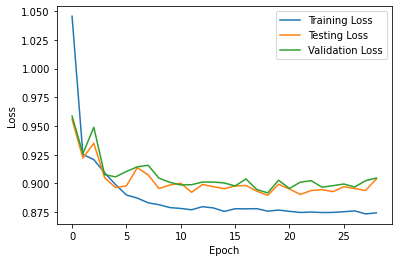

Test accuracy: 57.1571488120050049%


In [15]:
Train_an_MLP_and_eval(3000,100,10,True,0.5,train_dataloader_2,validation_dataloader_2,test_dataloader_2,wd = 0.01)

# Task 5

####Prepare Dataloaders for RNNs

In [73]:
BATCH_SIZE_3 = 32

X_train_tensor_3 = torch.Tensor(X_train_np_3_c.astype('float32'))
X_test_tensor_3  = torch.Tensor(X_test_np_3_c.astype('float32'))

train_dataset_3 = TensorDataset(X_train_tensor_3,y_train_tensor)
test_dataset_3 = TensorDataset(X_test_tensor_3,y_test_tensor)

train_dataset_3, validation_dataset_3 = random_split(train_dataset_3,[0.9,0.1])

train_dataloader_3 = DataLoader(train_dataset_3, batch_size=BATCH_SIZE_3, shuffle=True) 
test_dataloader_3 = DataLoader(test_dataset_3, batch_size=BATCH_SIZE_3, shuffle=True) 
validation_dataloader_3= DataLoader(validation_dataset_3, batch_size=BATCH_SIZE_3, shuffle=True)


####Simple RNN Constructor for Task 5a

In [95]:
class RNN(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim, output_dim)

    def forward(self, x):
        _, hidden = self.rnn(x)
        out = self.fc(hidden.squeeze(0))
        return out

class GRU(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, dropout=0.5, recurrent_dropout=0.2):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_dim, hid_dim, batch_first=True, dropout=dropout, num_layers=3, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2 , output_dim)

    def forward(self, x):
        # x.shape = (batch_size, seq_len, input_dim)
        output, hidden = self.gru(x)
        # output.shape = (batch_size, seq_len, hid_dim * 2)
        # hidden.shape = (4, batch_size, hid_dim)

        # average across the sequence length
        output = torch.mean(output, dim=1)
        # output.shape = (batch_size, hid_dim * 2)

        out = self.fc(output)
        # out.shape = (batch_size, output_dim)

        return out


0
0.8612276494503022
1
0.817803579568863
2
0.7883851397037506
3
0.7646399819850922
4
0.7487832353512446
5
0.7456901339689891
6
0.7374881166219711
7
0.7841561663150788
8
0.7446760529279709
9
0.7630399753650029
10
0.7623692733049393
11
0.7749565668900807
12
0.7710569697618485
13
0.7956694318850835
14
0.8238165672620138
15
0.8200505179166794
16
0.8539878726005554
Early stopping
Lowest Valid Loss = 0.7374881166219711


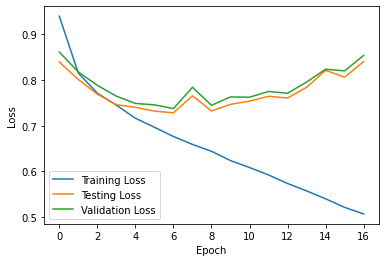

Test accuracy: 67.3947478115881609%


In [96]:
rnn = RNN(300, 20, 3)
gru = GRU(300, 20, 3)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(gru.parameters())

best_loss = float('inf')
counter = 0
train_list = []
valid_list = []
test_list = []
lowest_valid_loss = float('inf')

num_epochs = 100
for epoch in range(0,num_epochs):
    print(epoch)
    train_loss = 0.0
    for i, batch in enumerate(train_dataloader_3, 0):
        # Get the input and target tensors from the batch
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = gru(inputs)
        #targets = torch.eye(3)[targets.long()] ########### For gru
        targets = targets.type(torch.LongTensor)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # record train loss
    train_list.append(train_loss / len(train_dataloader_3))

    # record validation loss
    valid_loss = 0.0
    gru.eval()  
    for i, data in enumerate(validation_dataloader_3, 0):
        inputs, targets = data
        outputs = gru(inputs)
        targets = targets.type(torch.LongTensor)
        loss = loss_function(outputs, targets)
        valid_loss += loss.item()
    valid_list.append(valid_loss / len(validation_dataloader_3))
    print(valid_loss / len(validation_dataloader_3))
    # update lowest validation loss
    if lowest_valid_loss > valid_loss / len(validation_dataloader_3):
        lowest_valid_loss = valid_loss / len(validation_dataloader_3)

     # record test loss
    gru.eval()  
    testing_loss = 0.0
    with torch.no_grad():
        for data, target in test_dataloader_3:
            output = gru(data)
            target = target.type(torch.LongTensor)
            loss = loss_function(output, target)
            testing_loss += loss.item() * data.size(0)
    testing_loss /= len(test_dataloader_3.dataset)
    test_list.append(testing_loss)

    # early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        counter = 0
        torch.save(gru.state_dict(), 'best_model.pt')
    else:
        counter += 1
        if counter >= 10:
            print("Early stopping")
            break

print("Lowest Valid Loss = " + str(lowest_valid_loss)) 
# Use the best model obtained from the early stopping process
gru.load_state_dict(torch.load('best_model.pt'))
plot_loss(train_list, test_list, valid_list)    
test_acc(gru, test_dataloader_3)

####GRU Constructor for Task 5b

#Hyper Tuning

In [ ]:
"""
def grid_search(train_dataloader, validation_dataloader, test_dataloader, learning_rate_list, weight_decay_list, dropout_p_list, use_bn_list, activation_list):
    best_loss = float('inf')
    best_lr = None
    best_wd = None
    best_dp = None
    best_bn = None
    best_activation = None
    
    for lr in learning_rate_list:
        for wd in weight_decay_list:
            for dp in dropout_p_list:
                for bn in use_bn_list:
                    for activation in activation_list:
                        mlp = MLP2(dropout_p=dp, use_bn=bn, activation=activation)
                        loss_function = nn.CrossEntropyLoss()
                        optimizer = torch.optim.RAdam(mlp.parameters(), lr=lr, weight_decay=wd)

                        train_list = []
                        valid_list = []
                        test_list = []

                        patience = 10
                        counter = 0
                        lowest_valid_loss = 100

                        for epoch in range(0, 1000):
                            train_loss = 0.0
                            for i, data in enumerate(train_dataloader, 0):
                                inputs, targets = data

                                optimizer.zero_grad()
                                outputs = mlp(inputs)
                                targets = targets.type(torch.LongTensor)
                                loss = loss_function(outputs, targets)
                                loss.backward()
                                optimizer.step()
                                train_loss += loss.item()

                            # record train loss
                            train_list.append(train_loss / len(train_dataloader))

                            # record validation loss
                            valid_loss = 0.0
                            mlp.eval()
                            for i, data in enumerate(validation_dataloader, 0):
                                inputs, targets = data
                                outputs = mlp(inputs)
                                targets = targets.type(torch.LongTensor)
                                loss = loss_function(outputs, targets)
                                valid_loss += loss.item()
                            valid_list.append(valid_loss / len(validation_dataloader))

                            # record test loss
                            mlp.eval()
                            testing_loss = 0.0
                            with torch.no_grad():
                                for data, target in test_dataloader:
                                    output = mlp(data)
                                    target = target.type(torch.LongTensor)
                                    loss = loss_function(output, target)
                                    testing_loss += loss.item() * data.size(0)

                            testing_loss /= len(test_dataloader.dataset)
                            test_list.append(testing_loss)

                            # early stopping
                            if valid_loss / len(validation_dataloader) < best_loss:
                                best_loss = valid_loss / len(validation_dataloader)
                                best_lr = lr
                                best_wd = wd
                                best_dp = dp
                                best_bn = bn
                                best_activation = activation
                                counter = 0
                                torch.save(mlp.state_dict(), 'best_model.pt')
                            else:
                                counter += 1
                                if counter >= patience:
                                    break

                        # Use the best model obtained from the early stopping process
                        mlp.load_state_dict(torch.load('best_model.pt'))


    print("Grid search finished.")
    print(f"Best hyperparameters: lr={best_lr}, wd={best_wd}, dp={best_dp}, bn={best_bn}, activation={best_activation}")
    print(f"Best validation loss: {best_loss}")
    print(f"Test accuracy: {test_acc(mlp, test_dataloader)}")
    """


'\ndef grid_search(train_dataloader, validation_dataloader, test_dataloader, learning_rate_list, weight_decay_list, dropout_p_list, use_bn_list, activation_list):\n    best_loss = float(\'inf\')\n    best_lr = None\n    best_wd = None\n    best_dp = None\n    best_bn = None\n    best_activation = None\n    \n    for lr in learning_rate_list:\n        for wd in weight_decay_list:\n            for dp in dropout_p_list:\n                for bn in use_bn_list:\n                    for activation in activation_list:\n                        mlp = MLP2(dropout_p=dp, use_bn=bn, activation=activation)\n                        loss_function = nn.CrossEntropyLoss()\n                        optimizer = torch.optim.RAdam(mlp.parameters(), lr=lr, weight_decay=wd)\n\n                        train_list = []\n                        valid_list = []\n                        test_list = []\n\n                        patience = 10\n                        counter = 0\n                        lowest_valid

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchvision import transforms,datasets
import matplotlib.pyplot as plt
import numpy as np

"""
class MLP2(nn.Module):
    
    def __init__(self, dropout_p=0.5, use_bn=True, activation="relu"):
        super().__init__()
        hidden_1 = 100
        hidden_2 = 10
        
        if use_bn:
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(300, hidden_1),
                nn.BatchNorm1d(hidden_1),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(hidden_1, hidden_2),
                nn.BatchNorm1d(hidden_2),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(hidden_2, 3),
            )
        else:
            self.layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(300, hidden_1),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(hidden_1, hidden_2),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(hidden_2, 3),
            )
        
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "tanh":
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Invalid activation: {activation}")

    def forward(self, x):
        x = self.layers(x)
        x = self.activation(x)
        return x

learning_rate_list = [0.001]
weight_decay_list= [0.0,0.001,0.0001]
dropout_p_list = [0.0,0.3,0.5,0.7]
use_bn_list = [True]
activation_list = ["relu","sigmoid","tanh"]


grid_search(train_dataloader, validation_dataloader, test_dataloader, learning_rate_list, weight_decay_list, dropout_p_list, use_bn_list, activation_list)
"""

'\nclass MLP2(nn.Module):\n    \n    def __init__(self, dropout_p=0.5, use_bn=True, activation="relu"):\n        super().__init__()\n        hidden_1 = 100\n        hidden_2 = 10\n        \n        if use_bn:\n            self.layers = nn.Sequential(\n                nn.Flatten(),\n                nn.Linear(300, hidden_1),\n                nn.BatchNorm1d(hidden_1),\n                nn.ReLU(),\n                nn.Dropout(dropout_p),\n                nn.Linear(hidden_1, hidden_2),\n                nn.BatchNorm1d(hidden_2),\n                nn.ReLU(),\n                nn.Dropout(dropout_p),\n                nn.Linear(hidden_2, 3),\n            )\n        else:\n            self.layers = nn.Sequential(\n                nn.Flatten(),\n                nn.Linear(300, hidden_1),\n                nn.ReLU(),\n                nn.Dropout(dropout_p),\n                nn.Linear(hidden_1, hidden_2),\n                nn.ReLU(),\n                nn.Dropout(dropout_p),\n                nn.Linear(hidden_